In [97]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

In [98]:
print(librosa.__version__)
print(soundfile.__version__)
print(sklearn.__version__)

0.10.2.post1
0.12.1
1.4.2


In [99]:
def extract_feature(file, mfcc, chroma, mel):
    # Load the audio file
    X, sample_rate = librosa.load(file, sr=None)
    
    # Initialize the result array
    result = np.array([])

    # Extract MFCC features
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T, axis=0)
        result = np.hstack((result, mfccs))
    
    # Extract Chroma features
    if chroma:
        stft = np.abs(librosa.stft(X))
        chroma_feature = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma_feature))
    
    # Extract Mel spectrogram features
    if mel:
        mel_feature = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128, fmax=8000).T, axis=0)
        result = np.hstack((result, mel_feature))
    
    return result

In [100]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#Emotions to observe - using only sub-part of dataset
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [101]:
for file in glob.glob("D:\Emotion_recognition_audio\emotion-dataset/Actor_*[0-9]*/*"):
  file_name = os.path.basename(file)
  print(file_name)

03-01-01-01-01-01-01.wav
03-01-01-01-01-02-01.wav
03-01-01-01-02-01-01.wav
03-01-01-01-02-02-01.wav
03-01-02-01-01-01-01.wav
03-01-02-01-01-02-01.wav
03-01-02-01-02-01-01.wav
03-01-02-01-02-02-01.wav
03-01-02-02-01-01-01.wav
03-01-02-02-01-02-01.wav
03-01-02-02-02-01-01.wav
03-01-02-02-02-02-01.wav
03-01-03-01-01-01-01.wav
03-01-03-01-01-02-01.wav
03-01-03-01-02-01-01.wav
03-01-03-01-02-02-01.wav
03-01-03-02-01-01-01.wav
03-01-03-02-01-02-01.wav
03-01-03-02-02-01-01.wav
03-01-03-02-02-02-01.wav
03-01-04-01-01-01-01.wav
03-01-04-01-01-02-01.wav
03-01-04-01-02-01-01.wav
03-01-04-01-02-02-01.wav
03-01-04-02-01-01-01.wav
03-01-04-02-01-02-01.wav
03-01-04-02-02-01-01.wav
03-01-04-02-02-02-01.wav
03-01-05-01-01-01-01.wav
03-01-05-01-01-02-01.wav
03-01-05-01-02-01-01.wav
03-01-05-01-02-02-01.wav
03-01-05-02-01-01-01.wav
03-01-05-02-01-02-01.wav
03-01-05-02-02-01-01.wav
03-01-05-02-02-02-01.wav
03-01-06-01-01-01-01.wav
03-01-06-01-01-02-01.wav
03-01-06-01-02-01-01.wav
03-01-06-01-02-02-01.wav


In [102]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("D:\Emotion_recognition_audio\emotion-dataset/Actor_*[0-9]*/*"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [103]:
def load_data(test_size=0.25):
    # Placeholder for loading data, replace with your actual data loading logic
    data = load_iris()  # Replace with your dataset
    X = data.data
    y = data.target
    return train_test_split(X, y, test_size=test_size, random_state=42)


In [104]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [105]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [106]:
selector = SelectKBest(f_classif, k='all')  # Use 'all' or specify number of top features to select
x_train_selected = selector.fit_transform(x_train_scaled, y_train)
x_test_selected = selector.transform(x_test_scaled)

In [107]:
pca = PCA(n_components=0.95)  # Keep 95% of the variance
x_train_pca = pca.fit_transform(x_train_selected)
x_test_pca = pca.transform(x_test_selected)

In [108]:
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (100, 50), (200, 100), (300, 200, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000],  # Increased max_iter for better convergence
    'early_stopping': [True],
    'n_iter_no_change': [10, 20],
    'validation_fraction': [0.1, 0.2]
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(MLPClassifier(), param_grid, n_jobs=-1, cv=5, verbose=2)
grid_search.fit(x_train_pca, y_train)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(100,), (200,), (100, 50),
                                                (200, 100), (300, 200, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [1000], 'n_iter_no_change': [10, 20],
                         'solver': ['adam', 'sgd'],
                         'validation_fraction': [0.1, 0.2]},
             verbose=2)

In [109]:
best_params = grid_search.best_params_
model1 = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    alpha=best_params['alpha'],
    learning_rate=best_params['learning_rate'],
    max_iter=best_params['max_iter'],
    early_stopping=best_params['early_stopping'],
    n_iter_no_change=best_params['n_iter_no_change'],
    validation_fraction=best_params['validation_fraction']
)
model1.fit(x_train_pca, y_train)

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(300, 200, 100), learning_rate='adaptive',
              max_iter=1000, n_iter_no_change=20)

In [110]:
training_accuracy = model1.score(x_train_pca, y_train)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

Training Accuracy: 86.61%


In [111]:
test_accuracy = model1.score(x_test_pca, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 89.47%


In [113]:
ensemble_model = BaggingClassifier(
    estimator=MLPClassifier(
        hidden_layer_sizes=best_params['hidden_layer_sizes'],
        activation=best_params['activation'],
        solver=best_params['solver'],
        alpha=best_params['alpha'],
        learning_rate=best_params['learning_rate'],
        max_iter=best_params['max_iter'],
        early_stopping=best_params['early_stopping'],
        n_iter_no_change=best_params['n_iter_no_change'],
        validation_fraction=best_params['validation_fraction']
    ),
    n_estimators=10,  # Number of base estimators
    random_state=42
)

ensemble_model.fit(x_train_pca, y_train)

BaggingClassifier(estimator=MLPClassifier(activation='tanh',
                                          early_stopping=True,
                                          hidden_layer_sizes=(300, 200, 100),
                                          learning_rate='adaptive',
                                          max_iter=1000, n_iter_no_change=20),
                  random_state=42)

In [114]:
ensemble_training_accuracy = ensemble_model.score(x_train_pca, y_train)
print(f"Ensemble Training Accuracy: {ensemble_training_accuracy * 100:.2f}%")

Ensemble Training Accuracy: 88.39%


In [115]:
ensemble_test_accuracy = ensemble_model.score(x_test_pca, y_test)
print(f"Ensemble Test Accuracy: {ensemble_test_accuracy * 100:.2f}%")

Ensemble Test Accuracy: 89.47%


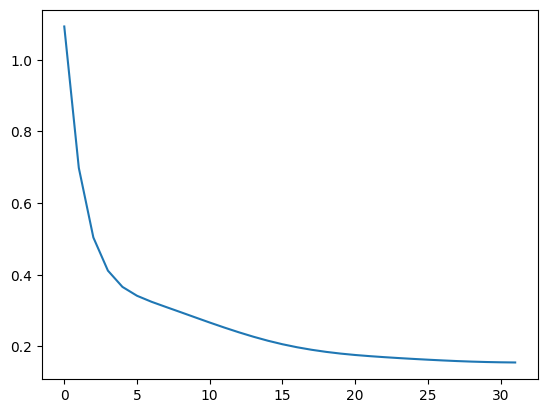

In [116]:
# Plotting graph for MLPClassifier

loss_values1 = model1.loss_curve_
plt.plot(loss_values1)
plt.show()

In [117]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(ensemble_model, open('D:\Emotion_recognition_audio\Code\mysite\polls\emotion_classification-model.pk2', 'wb'))